In [1]:
import cv2
import math
from matplotlib import pyplot as plt
import numpy as np
import os
import time
import json
%matplotlib inline

def from_json(file):
    coordinates = ["x", "y"]
    joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
            "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle",
            "right_eye", "right_ear","left_eye", "left_ear", "nose ", "neck"]
    with open(file, 'r') as inf:
        out = json.load(inf)

    liste = []
    for fr in out["frames"]:
        l_joints = []
        for j in joints_list[:12]:
            l_coo = []
            for xy in coordinates:
                l_coo.append(fr[j][xy])
            l_joints.append(l_coo)
        liste.append(l_joints)

    return np.array(liste)

class Node():
    def __init__(self, x1, y1, x2, y2):
        self.bbox = [x1, y1, x2, y2]
        l = abs(x1-x2)
        w = abs(y1-y2)
        self.area = l*w # (l+w)/float(l*w)
        self.center = [(x1+x2)/2, (y1+y2)/2]
        self.children = []
    def add_child(self, no):
        self.children.append(no)

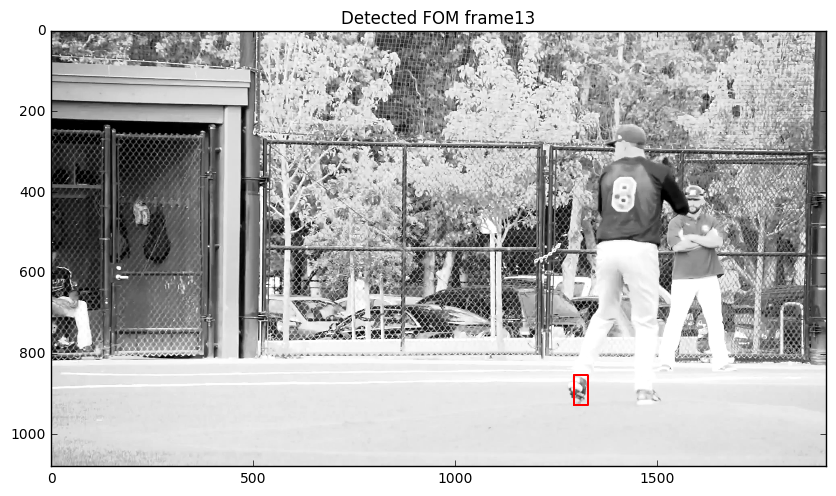

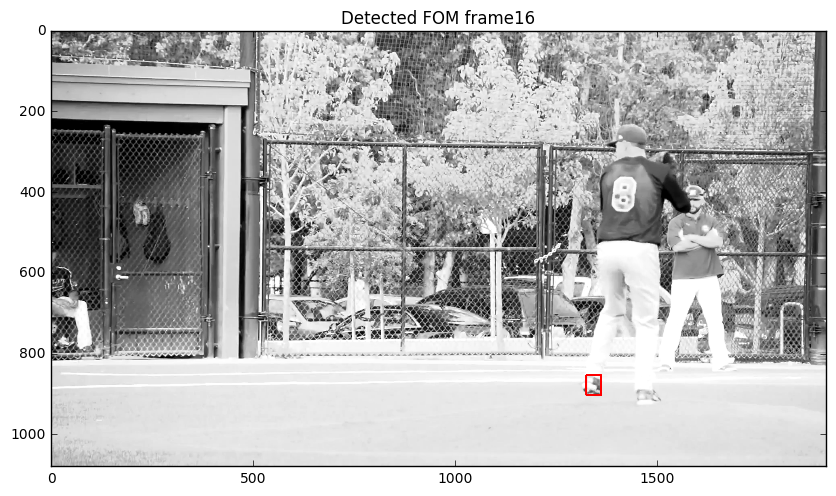

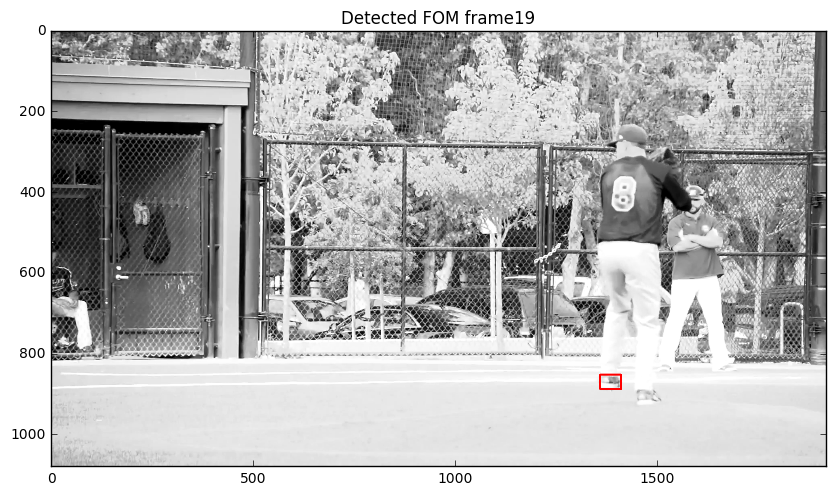

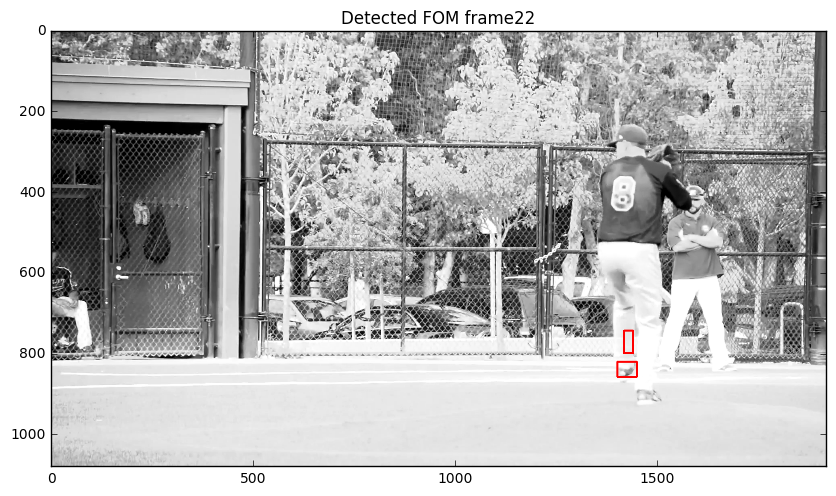

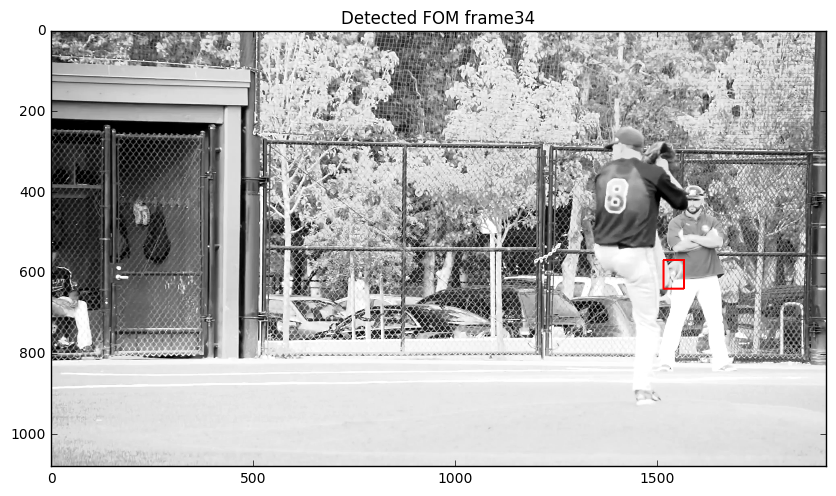

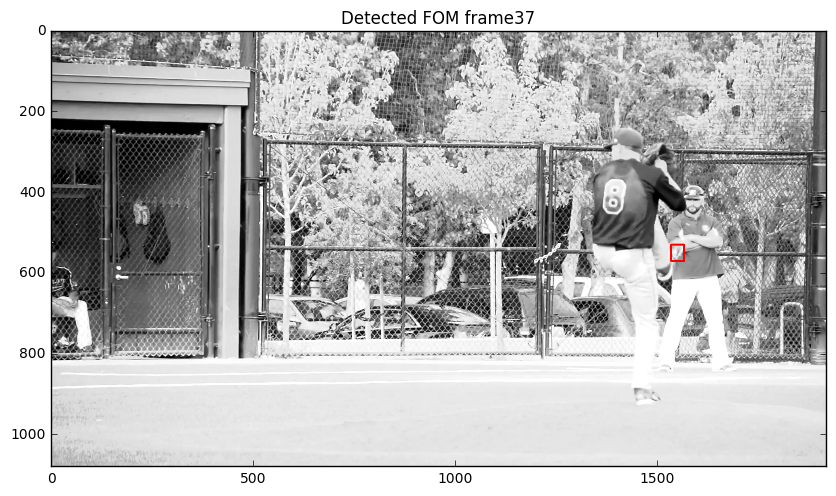

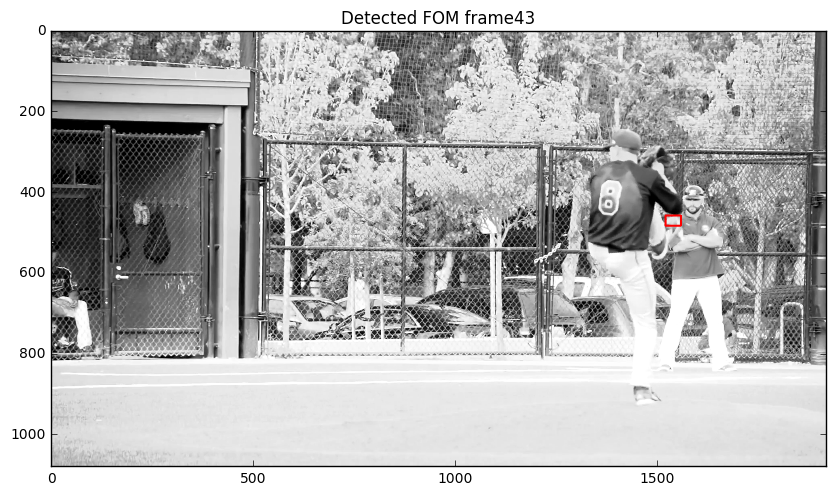

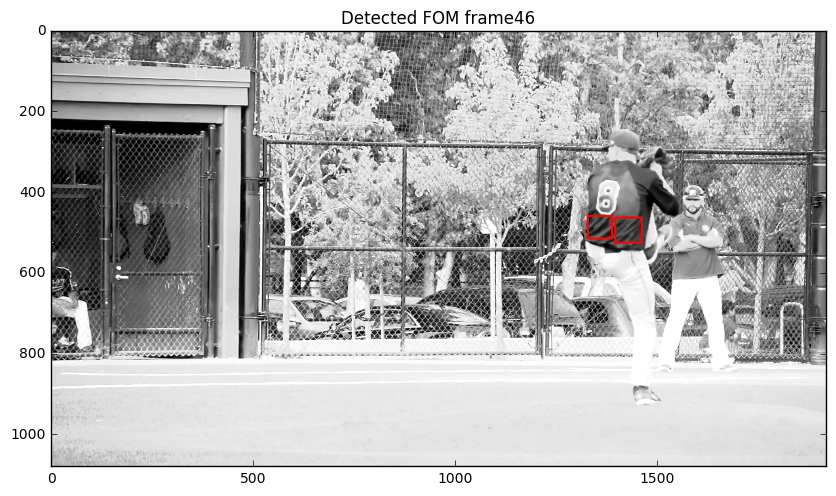

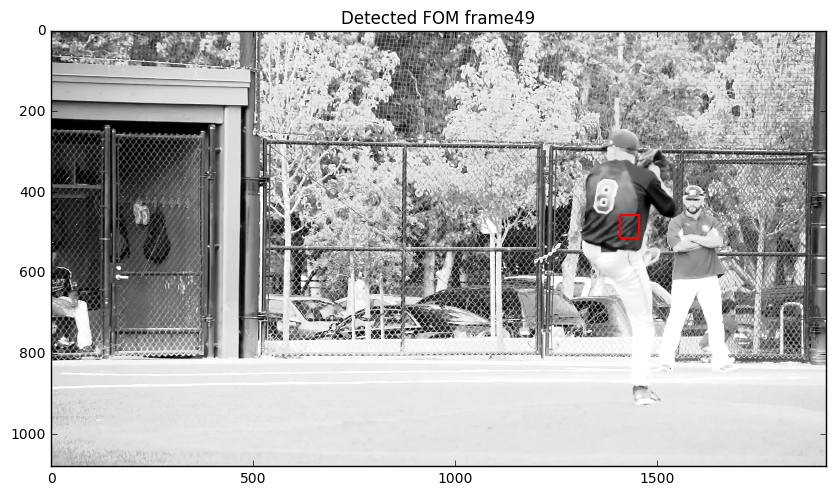

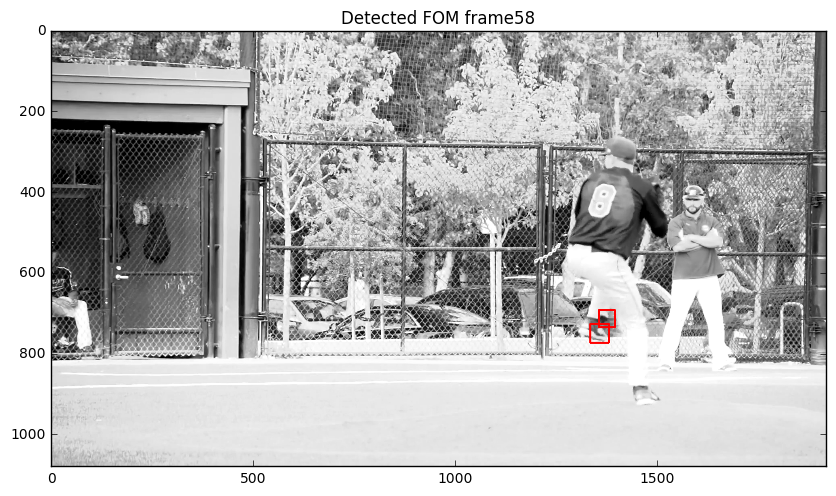

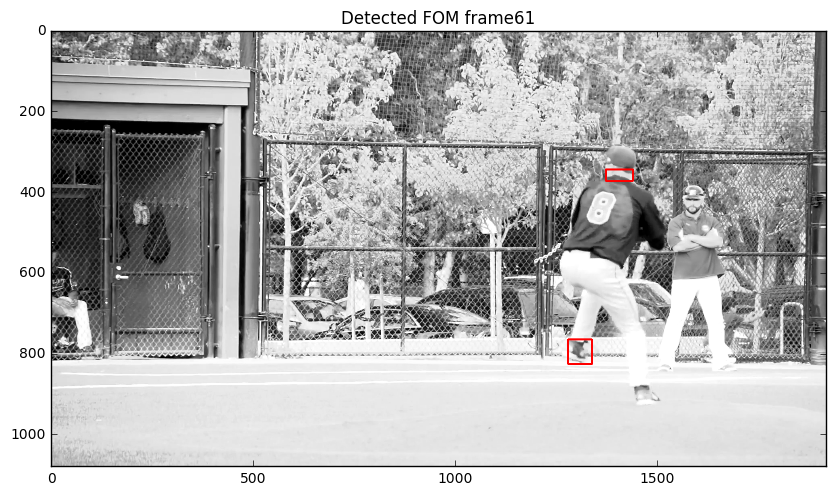

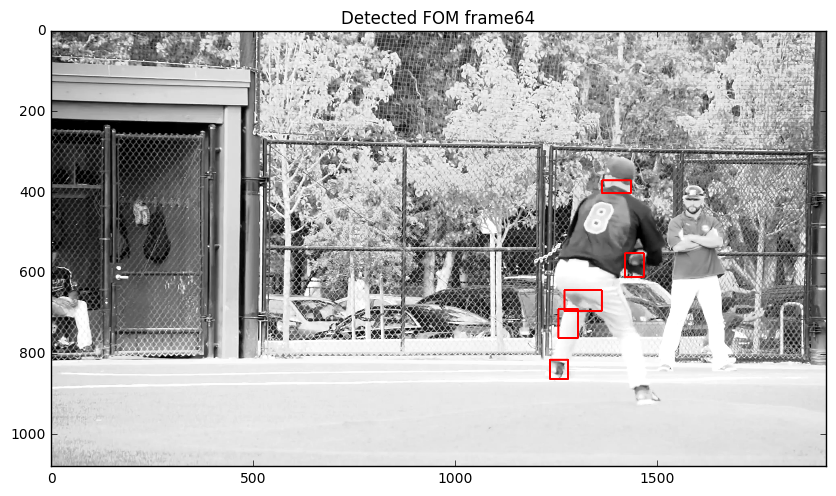

KeyboardInterrupt: 

In [8]:

# PARAMETERS
def detect_ball(folder, joints_array=None, template = "%03d.jpg", min_area = 400, plotting=True):
    # length = len(os.listdir(folder))
    # images = [cv2.imread(folder+template %idx, cv2.IMREAD_GRAYSCALE) for idx in range(length)] #IMG_TEMPLATE.format(idx), )

    cap = cv2.VideoCapture(folder)
    images=[]
    start = time.time()

    candidates_per_frame = []
    candidate_values = []
    whiteness_values = []
    location = []
    frame_indizes = []
    balls = []
    t=0
    temp=0
    frame_before_close_wrist = False
    while True: #t<150:
        ret, frame = cap.read()
        candidates_per_frame.append([])
        if frame is None:
            break
        if temp%3 !=0:
            temp+=1
            continue
        temp+=1
            
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # for t in range(1, length-1):
        if t<2:
            images.append(frame)
            t+=1
            continue

        im_tm1 = images[0]
        im_t = images[1]
        im_tp1 = frame
        delta_plus = cv2.absdiff(im_t, im_tm1)
        delta_0 = cv2.absdiff(im_tp1, im_tm1)
        delta_minus = cv2.absdiff(im_t,im_tp1)
        sp = cv2.meanStdDev(delta_plus)
        sm = cv2.meanStdDev(delta_minus)
        s0 = cv2.meanStdDev(delta_0)
        # print("E(d+):", sp, "\nE(d-):", sm, "\nE(d0):", s0)

        th = [
            sp[0][0, 0] + 3 * math.sqrt(sp[1][0, 0]),
            sm[0][0, 0] + 3 * math.sqrt(sm[1][0, 0]),
            s0[0][0, 0] + 3 * math.sqrt(s0[1][0, 0]),
        ]

        #print("Thresholds:", th)
        """
        # NAIVE THRESHOLD
        start = time.time()
        dbp = threshold(delta_plus, th[0])
        dbm = threshold(delta_minus, th[1])
        db0 = threshold(delta_0, th[2], invert=True)

        detect_naive = combine(dbp, dbm, db0)
        naive_time = (time.time() - start) * 1000
        """

        # OPENCV THRESHOLD

        ret, dbp = cv2.threshold(delta_plus, th[0], 255, cv2.THRESH_BINARY)
        ret, dbm = cv2.threshold(delta_minus, th[1], 255, cv2.THRESH_BINARY)
        ret, db0 = cv2.threshold(delta_0, th[2], 255, cv2.THRESH_BINARY)

        detect = cv2.bitwise_not(cv2.bitwise_and(cv2.bitwise_and(dbp, dbm),
                        cv2.bitwise_not(db0)))

        # CONNECTED BOX
        # The original `detect` image was suitable for display, but it is "inverted" and not suitable
        # for component detection; we need to invert it first.
        start = time.time()
        nd = cv2.bitwise_not(detect)
        # only stats is used, not num, labels, centroids
        num, labels, stats, centroids = cv2.connectedComponentsWithStats(nd, ltype=cv2.CV_16U)
        # We set an arbitrary threshold to screen out smaller "components"
        # which may result simply from noise, or moving leaves, and other
        # elements not of interest.


        d = detect.copy()
        candidates = list()
        for stat in stats[1:]:
            area = stat[cv2.CC_STAT_AREA]
            if area < min_area:
                continue # Skip small objects (noise)

            lt = (stat[cv2.CC_STAT_LEFT], stat[cv2.CC_STAT_TOP])
            rb = (lt[0] + stat[cv2.CC_STAT_WIDTH], lt[1] + stat[cv2.CC_STAT_HEIGHT])
            bottomLeftCornerOfText = (lt[0], lt[1] - 15)

            candidates.append((lt, rb, area))

        #plt.figure(figsize=(10, 10), edgecolor='k')

        # MOTION MODEL

        # Thinning threshold.
        psi = 0.7
        # Area matching threshold.
        gamma = 20 #0.4 changed to see all candidates
        area_max = 0

        fom_detected = False
        start = time.time()
        col = len(candidates)
        #print("number of candidates", col)
        sub_regions = list()

        #if len(candidates)>0:
         #   wrist_position=joints_array[t-1, [1, 2, 4, 5],:] # ellbows and wrists
            #box = np.sqrt(min_area)
            #patch_right = [wrist_position[0,0]-box,wrist_position[0,0]+box, wrist_position[0,1]-box, wrist_position[0,1+box]
        index = []
        close_to_wrist=False
        for i, candidate in enumerate(candidates):

            # The first two elements of each `candidate` tuple are
            # the opposing corners of the bounding box.
            x1, y1 = candidate[0]
            x2, y2 = candidate[1]
            center = [(x1+x2)/2, (y1+y2)/2]

            no = Node(x1, y1, x2, y2)
            candidates_per_frame[-1].append(no)
            if t>0 and candidates_per_frame[-2]!=[]:
                for nodes in candidates_per_frame[-2]:
                    nodes.add_child(no)
                    # print("previous detection", nodes.bbox, "gets child", no.bbox)
            """
            # CLOSE WRIST IDEA
            if frame_before_close_wrist:
                bbox = [np.min(joints_array[t-1, :, 0]), np.max(joints_array[t-1,:, 0]),
                       np.min(joints_array[t-1, :, 1]), np.max(joints_array[t-1, :, 1])]
                # if not near somewhere the body
                if not (bbox[0]<center[0]<bbox[1] and bbox[2]<center[1]<bbox[3]):
                    #print(bbox, center)
                    print("BALL DETECTED, ", center)

            if close_to_wrist==False:
                # if center of detection box is close enough (2*length of min_area), close_to_wrist = True
                distances = [np.linalg.norm(center-wrist_position[i]) for i in range(len(wrist_position))]
                if np.any(distances<3*np.sqrt(min_area)):# or np.linalg.norm(center-wrist_position[1])<2*np.sqrt(min_area):
                    close_to_wrist = True
                    print("close to wrist with center:", center)
            """
            # We had placed the candidate's area in the third element of the tuple.
            actual_area = candidate[2]

            # For each candidate, estimate the "radius" using a distance transform.
            # The transform is computed on the (small) bounding rectangle.
            cand = nd[y1:y2, x1:x2]
            dt = cv2.distanceTransform(cand, distanceType=cv2.DIST_L2, maskSize=cv2.DIST_MASK_PRECISE)
            radius = np.amax(dt)

            # "Thinning" of pixels "close to the center" to estimate a
            # potential FOM path.
            ret, Pt = cv2.threshold(dt, psi * radius, 255, cv2.THRESH_BINARY)

            # TODO: compute actual path lenght, using best-fit straight line
            #   along the "thinned" path.
            # For now, we estimate it as the max possible lenght in the bounding box, its diagonal.
            w = x2 - x1
            h = y2 - y1
            path_len = math.sqrt(w * w + h * h)
            expected_area = radius * (2 * path_len + math.pi * radius)

            area_ratio = abs(actual_area / expected_area - 1)
            #print(area_ratio)

            location.append(center)
            index.append(i)
            #area = candidates[i][2]
            #candidate_values.append(area_ratio)
            #patch = im_t[y1:y2, x1:x2]
            #whiteness_values.append(np.mean(patch))
            frame_indizes.append(t-1)

        ### BALL DETECTION:
        if t>1 and candidates_per_frame[-2]!=[]:
            area_diff=[]
            nodes = []
            for cand in candidates_per_frame[-2]:
                for c in cand.children:
                    area_diff.append(abs(cand.area- c.area))
                    nodes.append(c)
            print(t, area_diff)
            if area_diff!=[] and np.min(area_diff)<min_area:
                if len(balls)>1 and len(np.where(np.array(area_diff)<min_area)[0])>1:
                    d = []
                    for j, n in enumerate(nodes):
                        if area_diff[j]<min_area:
                            p1 =  np.array([(balls[0][0]+balls[0][2])/2, (balls[0][1]+balls[0][3])/2])
                            p2 =  np.array([(balls[1][0]+balls[1][2])/2, (balls[1][1]+balls[1][3])/2])
                            p3 =  np.array([(n.bbox[0]+n.bbox[2])/2, (n.bbox[1]+n.bbox[3])/2])
                            d.append(np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1))
                        else: d.append(np.inf)
                    balls.append(nodes[np.argmin(d)].bbox)
                else:
                    balls.append(nodes[np.argmin(area_diff)].bbox) # ändern statt d area_diff
                # print(balls)
            else:
                balls = []
        else:
            balls = []
        if len(balls)==5:
            print("release frame", t-5)
            break
        ###

        if plotting and len(candidates)>0: #len(balls)>0:
            #print("DETECTED", t-1, whiteness_values[-1], candidate_values[-1])
            plt.figure(figsize=(10, 10), edgecolor='r')
            # print(candidates[fom])
            img = np.tile(np.expand_dims(im_t.copy(), axis = 2), (1,1,3))
            #print(img.shape)
            #for jo in wrist_position:
             #   cv2.circle(img, (int(jo[0]), int(jo[1])), 8, [255,0,0], thickness=-1)

            for fom in index: # einfuegen falls alles plotten
                cv2.rectangle(img, candidates[fom][0], candidates[fom][1],[255,0,0], 4)
            #cv2.rectangle(img,tuple(balls[-1][:2]), tuple(balls[-1][2:]), [255,0,0], 4)
                              
            plt.imshow(img, 'gray')
            plt.title("Detected FOM frame"+ str(temp))
            plt.show()
        """
        if close_to_wrist:
            frame_before_close_wrist = True
        else:
            frame_before_close_wrist = False
        """
        t+=1
        images[0] = images[1].copy()
        images[1] = frame
    print("time for %s frames without plotting"%t, (time.time() - start) * 1000)

    return frame_indizes, location, candidates_per_frame

# 40mph_1us_1.2f_170fps_40m_sun # 40mph_10us_6f_100fps_40m_cloudy # 40mph_10us_11f_100fps_noisy.avi
#frame_indizes, location, candidates_per_frame = detect_ball("/Volumes/Nina Backup/Nina's Pitch/40mph_10us_6f_100fps_40m_cloudy.avi")
#sys.exit()

example = "#8 RHP Cole Johnson" # #15 Brandon Coborn # #10 Matt Glomb #26 RHP Tim Willites" (willites camera moves) #00 RHP Devin Smith # #10 Matt Glomb
BASE = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"+example+".mp4" #"data/Matt_Blais/" # für batter: pic davor, 03 streichen und (int(idx+1))
joints_path = "/Volumes/Nina Backup/high_quality_outputs/"+example+".json"

#BASE = "/Volumes/Nina Backup/CENTERFIELD/4f7477b1-d129-4ff7-a83f-ad322de63b24.mp4"
#joints_path = "/Volumes/Nina Backup/outputs/new_videos/cf/490770_4f7477b1-d129-4ff7-a83f-ad322de63b24_pitcher.json"
#joints = from_json(joints_path)[:,:12,:]
#print(joints.shape)
frame_indizes, location, candidates_per_frame = detect_ball(BASE, joints_array = None, min_area=400)

### ONLY DETECTION

In [ ]:


balls = []
min_area = 400
for i in range(len(candidates_per_frame)):
    if candidates_per_frame[i]!=[]:
        area_diff=[]
        nodes = []
        for cand in candidates_per_frame[i]:
            for c in cand.children:
                area_diff.append(abs(cand.area- c.area))
                nodes.append(c)
        print(i, area_diff)
        if area_diff!=[] and np.min(area_diff)<min_area:
            if len(balls)>1 and len(np.where(np.array(area_diff)<min_area)[0])>1:
                d = []
                for j, n in enumerate(nodes):
                    if area_diff[j]<min_area:
                        p1 =  np.array([(balls[0][0]+balls[0][2])/2, (balls[0][1]+balls[0][3])/2])
                        p2 =  np.array([(balls[1][0]+balls[1][2])/2, (balls[1][1]+balls[1][3])/2])
                        p3 =  np.array([(n.bbox[0]+n.bbox[2])/2, (n.bbox[1]+n.bbox[3])/2])
                        d.append(np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1))
                    else: d.append(np.inf)
                balls.append(nodes[np.argmin(d)].bbox)
            else:
                balls.append(nodes[np.argmin(area_diff)].bbox) # ändern statt d area_diff
            # print(balls)
        else:
            balls = []
    else:
        balls = []
    if len(balls)==5:
        print("release frame", i-5)
        break
print(balls)
balls = np.array(balls)
plt.scatter(balls[:,0], balls[:,1])
plt.ylim(1000, 0)
plt.xlim(0,2000)
plt.show()

In [ ]:
#print(candidate_values)
#print(np.argmax(candidate_values))
#print(np.argsort(candidate_values))
#print(frame_indizes)
#print(whiteness_values)
#print(delta_plus.shape, delta_0.shape, delta_minus.shape)
location = np.array(location)
plt.scatter(location[:,0], location[:,1])
plt.show()

def find_consecutive_frame():
    count =0
    frame = 0
    results=[]
    for detection in range(len(frame_indizes)):
        same_frame = frame_indizes[detection]==frame
        frame = frame_indizes[detection]
        bbox = [np.min(joints[frame, :, 0]), np.max(joints[frame,:, 0]),
                       np.min(joints[frame, :, 1]), np.max(joints[frame, :, 1])]
        if bbox[0]<location[detection, 0]<bbox[1] and bbox[2]<location[detection, 1]<bbox[3]:
            if not same_frame:
                count = 0
            continue
        #distance = min([np.linalg.norm(location[detection]-joints[frame, i]) for i in range(12)])
        if np.all(joints[frame, :, 1]>location[detection,1]):
            count+=1
        elif not same_frame:
            count = 0

        if count==3:
            print("found three points after another", frame)
            results.append(frame)
    return results

#res = find_consecutive_frame()
#print("results of find_consecutive_frame", res)

# find highest detections
def consecutive_highest_candidates(location, frame_indizes):
    a = np.argsort(location[:,1])
    x = np.array(frame_indizes)[a]
    result = np.median(x[:5])
    print("results of median of lowest frames", result)

    # find consecutive frames in highest ones
    found=False
    nr = 10
    while not found:
        sort_x = np.sort(x[:nr])
        print(sort_x)
        count=0
        for i in range(1, len(sort_x)):
            if abs(sort_x[i]-sort_x[i-1])==1:
                count+=1
            else:
                if count>2:
                    found=True
                    print("found consecutive frame", sort_x[i-2])
                    result = sort_x[i-2]
                    break
                count=0
        print("just argmin", frame_indizes[np.argmin(location[:,1])])
        nr+=10
    return result

# look for points which are on a line, such that cross product is zero

plt.scatter(frame_indizes, location[:,1])
plt.plot(joints[:, 2,1], color = "green")
plt.show()
plt.scatter(frame_indizes, np.gradient(location[:,1]))
#plt.plot(joints[:, 2,1], color = "green")
plt.show()
plt.scatter(frame_indizes, location[:,0])
plt.plot(joints[:, 2,0], color = "green")
plt.show()
plt.scatter(location[:,0], location[:,1])
plt.show()